In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [27]:
data = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/data.csv', index_col = 0)
#labels = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/labels.csv')
eigenvalues = pickle.load( open( "eigenvalues_first_800.pkl", "rb" ) )
eigenvectors = pickle.load( open( "eigenvectors_first_800.pkl", "rb" ) )

In [28]:
mean_arr = np.mean(data, 0)
var_arr = np.var(data, 0)
df = data.drop(data.columns[np.argwhere(np.array(var_arr == 0)).flatten()], axis = 1)
mean_arr = np.mean(df, 0)
var_arr = np.var(df, 0)
min_var = 2
df.drop(df.columns[np.argwhere(np.array(var_arr < min_var)).flatten()], axis = 1, inplace = True)
mean_arr = np.mean(df, 0)
var_arr = np.var(df, 0)
df = (df - mean_arr)/(var_arr ** (1/2))
df = np.real(np.array(df@eigenvectors))


In [104]:
from sklearn.cluster import KMeans

n = df.shape[0]
n_subsample_fraction = int(0.8*n)
K_max = 10
K_array = list(range(2,K_max+1))
M = 5
for i, K in enumerate(K_array):
    M_arr = np.zeros((M,n,n))
    J_arr = np.zeros((M,n,n))
    for m in range(M):
        indices = np.random.choice(np.array(range(n)), n_subsample_fraction, replace = False)
        
        chosen_samples = np.zeros(n)
        chosen_samples[indices] = 1
        J_m = np.reshape(chosen_samples, (-1, 1))@np.reshape(chosen_samples, (1, -1))
        
        current_data = df[indices, :]
        km = KMeans(n_clusters=K, random_state=0, n_init = 1).fit(current_data)
        labels = km.predict(current_data)
        
        connectivity = np.zeros((n_subsample_fraction, n_subsample_fraction))
        for k in range(K):
            samples_with_current_label = labels == k
            connectivity += np.reshape(samples_with_current_label, (-1, 1))@np.reshape(samples_with_current_label, (1, -1))
        
        
        M_m = np.zeros((n,n))
        M_m[np.argwhere(J_m == 1)[:, 0], np.argwhere(J_m == 1)[:, 1]] = connectivity.flatten()
        M_arr[m]
        

        

In [73]:
indices = np.random.choice(np.array(range(n)), n_subsample_fraction, replace = False)


In [125]:
indices = [0,2]
a = np.zeros(3)
a[indices] = 1
np.reshape(a, (-1, 1))@np.reshape(a, (1, -1))

array([[1., 0., 1.],
       [0., 0., 0.],
       [1., 0., 1.]])

In [69]:
print(np.reshape(a, (1, -1)).shape)

(1, 801)


In [72]:
np.reshape(a, (-1, 1))@np.reshape(a, (1, -1))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 1., 1.]])

In [76]:
current_data = df[indices, :]

In [77]:
print(current_data.shape)

(640, 800)


In [82]:
print(labels)

[3 7 5 0 7 9 8 2 7 7 9 4 3 4 5 1 8 3 2 9 6 3 3 3 0 9 3 7 3 8 4 8 1 4 9 9 6
 6 6 9 7 4 7 7 9 2 3 4 5 6 1 3 3 4 9 3 1 2 4 3 7 1 1 8 7 8 5 0 9 7 4 9 0 9
 7 9 3 6 0 8 9 5 1 5 4 6 0 9 5 1 6 3 8 1 5 1 7 8 2 2 8 9 4 3 3 5 4 5 3 2 2
 9 0 7 1 4 3 1 3 1 4 5 4 0 2 0 5 6 5 4 9 8 4 3 9 5 1 2 4 3 9 5 0 1 1 4 3 3
 3 3 2 2 9 1 4 5 9 1 2 9 7 6 7 1 8 0 4 2 7 1 8 4 8 2 4 9 7 5 3 4 3 3 7 2 6
 9 7 4 3 4 7 8 4 3 1 7 8 8 4 9 1 9 3 4 4 4 6 6 6 2 3 7 7 7 4 2 7 3 9 9 3 9
 4 7 3 2 7 5 3 2 9 3 1 2 9 7 7 2 9 8 2 0 3 8 9 5 7 3 3 8 4 4 4 3 4 3 8 2 7
 8 4 4 3 8 7 6 1 6 3 8 1 6 6 7 7 4 3 1 3 7 5 7 0 2 1 3 8 7 8 5 3 1 1 3 7 0
 2 0 3 9 5 1 4 5 7 3 2 5 3 4 7 3 7 0 3 4 8 3 2 3 9 3 2 3 8 2 9 4 2 4 8 7 4
 5 8 6 9 4 2 0 0 2 8 4 8 6 2 2 8 9 7 2 9 7 7 9 2 3 4 3 8 8 4 3 5 9 4 0 7 1
 7 6 5 3 1 0 4 3 7 4 8 4 4 0 7 0 9 5 7 8 0 9 2 3 3 0 3 6 4 4 4 4 2 3 7 8 7
 3 8 7 6 4 5 4 9 6 6 0 2 9 3 4 3 1 3 4 2 3 9 3 3 9 7 0 0 8 5 2 4 4 1 0 9 3
 8 3 4 1 4 6 8 9 6 9 7 9 4 1 6 4 8 6 4 7 9 9 5 4 1 0 5 8 7 3 4 2 4 5 6 8 9
 1 3 4 9 0 2 8 9 1 6 3 5 

In [86]:
np.sum(np.reshape(samples_with_current_label, (-1, 1))@np.reshape(samples_with_current_label, (1, -1)))

1444

In [94]:
a = np.ones((10,10))
b = a[:, [1,2,3,4]]
b = b[[1,2,3,4], :]

In [97]:
print(b)
b = 0 
print(b)
print(a)
a[]

0
0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [101]:
print(np.argwhere(J_m == 1).shape)

(409600, 2)


In [103]:
print(M_m[np.argwhere(J_m == 1)[:, 0], np.argwhere(J_m == 1)[:, 1]])

[0. 0. 0. ... 0. 0. 0.]


[ 1  2  3  4  5  7  8  9 10 11]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]]
[3 1 4 1 0 3 0 0 3 1]
[[1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]]


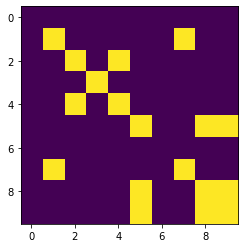

In [123]:
plt.imshow(M_m)
print(np.sort(indices)[:10])
print(M_m[:10, :10])
print(labels[:10])
print(connectivity[:10, :10])
plt.imshow(M_m[:10, :10])



In [126]:
print(np.argwhere(J_m == 1))

[[  1   1]
 [  1   2]
 [  1   3]
 ...
 [800 798]
 [800 799]
 [800 800]]
